In [ ]:
# !python -m spacy download en
# !python -m spacy download de

### PREPROCESSING DATA

In [5]:
def build_vocab(file_path, tokenizer):
    counter = Counter()
    with io.open(file_path, encoding="utf8") as f: 
        for string_ in f:
            counter.update(tokenizer(string_))
    return Vocab(counter)
    

In [6]:
de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

In [7]:
# Visualizing tonize in biuld_vocab
data = [
    'Two young, White males are outside near many bushes.' 
    ,'Several men in hard hats are operating a giant pulley system.'
    ,'A little girl climbing into a wooden playhouse.'
    ,'A man in a blue shirt is standing on a ladder cleaning a window.'
    ,'Two men are at the stove preparing food.'
    ,'A man in green holds a guitar while the other man observes his shirt.'
    ,'A man is smiling at a stuffed lion'
    ,'A trendy girl talking on her cellphone while gliding slowly down the street.'
    ,'A woman with a large purse is walking by a gate.'
]

for string_ in data[:2]:
    print(en_tokenizer(string_))
    counter.update(en_tokenizer(string_))
    print(counter)


['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Counter({'a': 2, 'b': 1, 'Two': 1, 'young': 1, ',': 1, 'White': 1, 'males': 1, 'are': 1, 'outside': 1, 'near': 1, 'many': 1, 'bushes': 1, '.': 1})
['Several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']
Counter({'a': 3, 'are': 2, '.': 2, 'b': 1, 'Two': 1, 'young': 1, ',': 1, 'White': 1, 'males': 1, 'outside': 1, 'near': 1, 'many': 1, 'bushes': 1, 'Several': 1, 'men': 1, 'in': 1, 'hard': 1, 'hats': 1, 'operating': 1, 'giant': 1, 'pulley': 1, 'system': 1})


In [11]:
def data_process(filepaths): 
    raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
    raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    data = [] 
    for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
        de_tensor = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de)], dtype=torch.long)
        en_tensor = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)], dtype=torch.long)
        
        data.append((de_tensor, en_tensor))
    return data

In [12]:
train_data = data_process(train_filepaths)
val_data   = data_process(val_filepaths)
test_data  = data_process(test_filepaths)

In [29]:
# Visualize in data process function 
raw_en_iter = iter(io.open(train_filepaths[1], encoding="utf8"))
print(list(raw_en_iter)[:10], "\n")
raw_en_iter = list(raw_en_iter)[:10]

['Two young, White males are outside near many bushes.\n', 'Several men in hard hats are operating a giant pulley system.\n', 'A little girl climbing into a wooden playhouse.\n', 'A man in a blue shirt is standing on a ladder cleaning a window.\n', 'Two men are at the stove preparing food.\n', 'A man in green holds a guitar while the other man observes his shirt.\n', 'A man is smiling at a stuffed lion\n', 'A trendy girl talking on her cellphone while gliding slowly down the street.\n', 'A woman with a large purse is walking by a gate.\n', 'Boys dancing on poles in the middle of the night.\n'] 



In [30]:
torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)], dtype=torch.long)

tensor([17458,  7359, 14847,   302,  7378, 31707,     8,  2323,    45,   615,
         9923,    51,  6871, 31707,     9,   248,  3963,  6175,     7,  7378,
           71, 14847,  9923,   460, 27623, 29000])

### DATALOADER

In [34]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 32 

PAD = de_vocab['<pad>']
BOS = de_vocab['<bos>']
EOS = de_vocab['<eos>']

In [74]:
def generate_batch(data_batch): 
    de_batch, en_batch = [], [] 
    for (de_item, en_item) in data_batch: 
        de_batch.append(torch.cat([torch.tensor([BOS]), de_item, torch.tensor([EOS])], dim=0))
        en_batch.append(torch.cat([torch.tensor([BOS]), de_item, torch.tensor([EOS])], dim=0))
    de_batch = pad_sequence(de_batch, padding_value=PAD)
    en_batch = pad_sequence(en_batch, padding_value=PAD)
    return de_batch, en_batch
        

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
test_iter  = DataLoader(test_data,  batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
val_iter   = DataLoader(val_data,   batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [75]:
# Visualize in one batch_size

batch = train_data[:7]
de_batch, en_batch = [], [] 
for (de_item, en_item) in batch: 
    print("de",de_item)
    print("en",en_item)
    
    de_batch.append(torch.cat([torch.tensor([BOS]), de_item, torch.tensor([EOS])], dim=0))
    en_batch.append(torch.cat([torch.tensor([BOS]), en_item, torch.tensor([EOS])], dim=0))
    

de tensor([ 3177,   498,   143,  1662,   490,  3079,   466, 11832,  4501,   383,
            2,     5, 28809, 29000])
en tensor([ 3116,  2074,  3963,    23,    39,  3716,   870,   569,   120,    19,
        27623, 29000])
de tensor([  502,  1662,  8838,    33,     9,  4947,     1, 28809, 29000])
en tensor([  280,  1612, 14847,   120,   146,  3716,    22, 31707,    43,     3,
            6, 27623, 29000])
de tensor([13904,   754,  2121,   171, 11832,  4947,     2,   906,    61, 28809,
        29000])
en tensor([17458,   843,  1667,   193,   711, 31707,   174,     3, 27623, 29000])
de tensor([13904,  7805, 11832, 13697,   992,  1202,  1778,  8686,  6750,    56,
         8925,    43,  4947,   148, 28809, 29000])
en tensor([17458,  7359, 14847, 31707,  1871,  2323,  7524,  1612,  8019, 31707,
           60,    60, 31707,   183, 27623, 29000])
de tensor([ 3177,  1662,   926,   902,    17,  8925,    78,   232,  1905, 28809,
        29000])
en tensor([ 3116,  1612,  3716,  2908,  9923,    23,

In [76]:
print([torch.tensor([BOS])])
print([de_item])
print([torch.tensor([EOS])])

# All will concatenate

[tensor([0])]
[tensor([13904,  7805,   234,  3479,     3,     3,  3044, 28809, 29000])]
[tensor([0])]


### Defining Model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')
    
    
def tokenize_de(text): 
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text): 
    return [tok.text for tok in spacy_en.tokenizer(text)]

2023-10-02 11:21:17.887695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 11:21:18.016848: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-02 11:21:18.867714: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages

In [2]:
SRC = Field(tokenize = tokenize_de, 
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_en, 
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True)

In [3]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

In [4]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [5]:
batch_size = 128 * 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = batch_size,
    sort_within_batch = True,
    sort_key = lambda x:len(x.src),
    device = device
)

### DEFINING THE MODEL

In [6]:

class Encoder(nn.Module): 
    def __init__(
        self, 
        input_dim, 
        emb_dim, 
        enc_hid_dim,
        dec_hid_dim, 
        dropout
    ):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        embedded = self.dropout(self.embedding(src))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        return outputs, hidden
    
class Attention(nn.Module): 
    def __init__(
        self,
        enc_hid_dim,
        dec_hid_dim,    
    ):
        super().__init__()
        self.atten = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(
        self,
        hidden,
        encoder_outputs,
        mask
    ): 
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.atten(torch.cat((hidden, encoder_outputs), dim = 2)))
        attention = self.v(energy).squeeze(2)
        attention = attention.masked_fill(mask == 0, -1e10)
        return F.softmax(attention, dim = 1)
    
class Decoder(nn.Module):
    def __init__(
        self, 
        output_dim, 
        emb_dim, 
        enc_hid_dim,
        dec_hid_dim, 
        dropout, 
        attention
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(
        self,
        input_,
        hidden,
        encoder_outputs,
        mask
    ):
        input_ = input_.unsqueeze(0)
        embedded = self.dropout(self.embedding(input_))
        a = self.attention(hidden, encoder_outputs, mask)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        return prediction, hidden.squeeze(0), a.squeeze(1)
    
    
class Seq2Seq(nn.Module):
    def __init__(
        self, 
        encoder,
        decoder,
        src_pad_idx, 
        device
    ):
        super().__init__()
        self.encoder = encoder 
        self.decoder = decoder 
        self.src_pad_idx = src_pad_idx
        self.device = device 
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask 
    
    def forward(
        self,
        src,
        src_len,
        trg,
        teacher_forcing_ratio = 0.5
    ):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim 
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src, src_len)
        input_ = trg[0,:]
        mask = self.create_mask(src)
        
        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input_, hidden, encoder_outputs, mask)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_ = trg[t] if teacher_force else top1
            
        return outputs
        

In [8]:
input_dim = len(SRC.vocab)
output_dim = len(TRG.vocab)
encoder_embedded_dim = 256
decoder_embedded_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
encoder_dropout = 0.5
decoder_dropout = 0.5

attention = Attention(
                      encoder_hidden_dim, 
                      decoder_hidden_dim
                     )

encoder = Encoder(
              input_dim, 
              encoder_embedded_dim, 
              encoder_hidden_dim, 
              decoder_hidden_dim, 
              encoder_dropout
             )

decoder = Decoder(
              output_dim, 
              decoder_embedded_dim, 
              encoder_hidden_dim, 
              decoder_hidden_dim, 
              decoder_dropout, 
              attention
             )

model = Seq2Seq(encoder, decoder, src_pad, device).to(device)

src_pad = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
optimizer = optim.Adam(model.parameters())



In [9]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

The model has 20,518,405 trainable parameters


In [10]:

def train(
    model, 
    iterator, 
    optimizer, 
    criterion, 
    clip
):
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        src, src_len = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(
    model, 
    iterator, 
    criterion
):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, src_len = batch.src
            trg = batch.trg
            output = model(src, src_len, trg, 0) 
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)
    

In [11]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 22s
	Train Loss: 5.398 | Train PPL: 220.908
	 Val. Loss: 4.855 |  Val. PPL: 128.426
Epoch: 02 | Time: 0m 21s
	Train Loss: 4.499 | Train PPL:  89.936
	 Val. Loss: 4.724 |  Val. PPL: 112.563
Epoch: 03 | Time: 0m 21s
	Train Loss: 4.168 | Train PPL:  64.560
	 Val. Loss: 4.482 |  Val. PPL:  88.449
Epoch: 04 | Time: 0m 21s
	Train Loss: 3.750 | Train PPL:  42.530
	 Val. Loss: 4.026 |  Val. PPL:  56.042
Epoch: 05 | Time: 0m 21s
	Train Loss: 3.335 | Train PPL:  28.065
	 Val. Loss: 3.757 |  Val. PPL:  42.817
Epoch: 06 | Time: 0m 21s
	Train Loss: 2.973 | Train PPL:  19.547
	 Val. Loss: 3.538 |  Val. PPL:  34.394
Epoch: 07 | Time: 0m 21s
	Train Loss: 2.692 | Train PPL:  14.759
	 Val. Loss: 3.332 |  Val. PPL:  27.994
Epoch: 08 | Time: 0m 21s
	Train Loss: 2.416 | Train PPL:  11.203
	 Val. Loss: 3.347 |  Val. PPL:  28.430
Epoch: 09 | Time: 0m 21s
	Train Loss: 2.194 | Train PPL:   8.971
	 Val. Loss: 3.296 |  Val. PPL:  26.997
Epoch: 10 | Time: 0m 21s
	Train Loss: 2.021 | Train PPL

In [12]:
model.load_state_dict(torch.load('tut4-model_test.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.225 | Test PPL:  25.151 |


### INFERENCE

In [37]:
def translate_sentence(
    sentence, 
    src_field, 
    trg_field, 
    model, 
    device, 
    max_len = 50
):
    model.eval()
    if isinstance(sentence, str):
        nlp = spacy.load("de")
        tokens = [token.text.lower() for token in nlp(sntence)]
    else: 
        tokens = [token.lower() for token in sentence]
        
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len    = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)
        
    mask = model.create_mask(src_tensor)
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len): 
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)
        attentions[i] = attention
        predict_token = output.argmax(1).item()
        trg_indexes.append(predict_token)
        
        if predict_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
            
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    return trg_tokens[1:], attentions[:len(trg_tokens) - 1]
    
    
def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    attention = attention.squeeze(1).cpu().detach().numpy()
    cax = ax.matshow(attention, cmap='bone')
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [42]:
example_idx = 11

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['vier', 'typen', ',', 'von', 'denen', 'drei', 'hüte', 'tragen', 'und', 'einer', 'nicht', ',', 'springen', 'oben', 'in', 'einem', 'treppenhaus', '.']
trg = ['four', 'guys', 'three', 'wearing', 'hats', 'one', 'not', 'are', 'jumping', 'at', 'the', 'top', 'of', 'a', 'staircase', '.']
predicted trg = ['four', 'guys', ',', 'one', 'three', 'hats', 'are', 'three', 'hats', 'are', 'jumping', 'off', 'a', 'rock', ',', 'jumping', 'off', 'a', 'staircase', '.', '<eos>']


/tmp/ipykernel_29656/1056383586.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/tmp/ipykernel_29656/1056383586.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


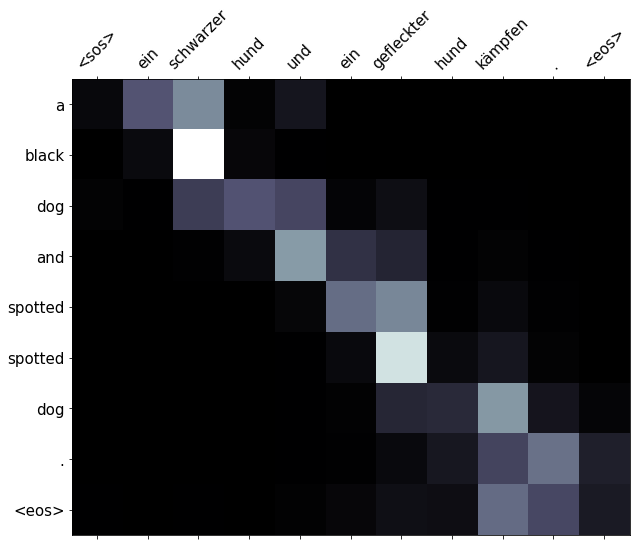

In [23]:
display_attention(src, translation, attention)

In [44]:
example_idx = 40

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'weißer', 'junge', 'fegt', 'eine', 'veranda', 'mit', 'einem', 'großen', 'besen', '.']
trg = ['a', 'young', 'white', 'male', 'is', 'sweeping', 'a', 'porch', 'with', 'a', 'large', 'broom', '.']


predicted trg = ['a', 'white', 'boy', 'is', 'a', 'porch', 'with', 'a', 'large', 'broom', '.', '<eos>']


/tmp/ipykernel_29656/2106749421.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/tmp/ipykernel_29656/2106749421.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


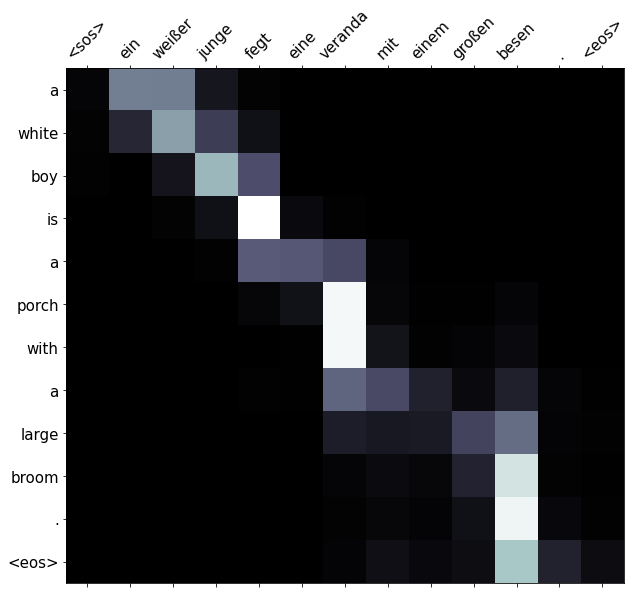

In [45]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')
display_attention(src, translation, attention)

### BLEU

In [46]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [47]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 28.19
